## Introduction

Libraries Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Read images
from matplotlib import image

# Customs matplotlib colors
from matplotlib import colors

# Read files from a directory
import glob

# Plot 1-1 matrix grids
from matplotlib.ticker import MultipleLocator

# Prints a neat progress bar
from tqdm.notebook import trange, tqdm

Images Import

In [2]:
# Load the images from the directory and normalize them
images = []
for filename in glob.glob('images/*.jpg'):
    images.append(np.asarray(image.imread(filename)) / 255)

Plotting Utilities

In [3]:
def plot_motion_vectors(motion_vectors, img_size, step=1):
    """
    Plot a vector field in a matrix grid each step pixels
    """
    fig, ax = plt.subplots(figsize=((max(img_size[1] // 20, 10), max(img_size[0] // 20, 10))))
    
    # Split vectors components into X and Y lists
    U, V = motion_vectors[::step, ::step, 1], motion_vectors[::step, ::step, 0]
    # Calculate the angle of each vector
    angle = np.arctan2(U, V)

    # Create a grid of points to draw the vectors from (center of each grid cell)
    X, Y = np.meshgrid(np.arange(0, img_size[0], step) + 0.5, np.arange(0, img_size[1], step)) + 0.5

    # Plot the grid
    plt.grid()

    # Draw the vectors from (Xi, Yi) to (Ui, Vi)
    # Their color is a lerp according to the angle
    # Their norm needs to be greater than 0 to be drawn
    plt.quiver(X, Y, U, V, angle, angles='xy', scale_units='xy', pivot="tail", scale=1, color='r', minshaft = 1, minlength=0)

    # Set the grid to be 1-1 and image sized
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlim(0, img_size[0])
    ax.set_ylim(0, img_size[1])

    # Show the result
    plt.show()

In [4]:
def plot_images_motion_vectors(motion_vectors, img_size):
    """
    Plot the motion vectors in 3 different images (X, Y, norm)
    """
    # Split vectors components into X and Y lists
    X, Y = motion_vectors[:, :, 0], motion_vectors[:, :, 1]
    # Calculate their norm
    N = np.sqrt(X ** 2 + Y ** 2)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=((max(img_size[1] // 20, 10), max(img_size[0] // 20, 10))))

    # Custom lerp color maps
    cmap_x = colors.LinearSegmentedColormap.from_list('mycmap', ['red', 'blue'])
    cmap_y = colors.LinearSegmentedColormap.from_list('mycmap2', ['green', 'yellow'])
    cmap_n = colors.LinearSegmentedColormap.from_list('mycmap3', ['white', 'black'])

    # Plot the images
    im1 = ax1.imshow(X, cmap=cmap_x)
    fig.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(Y, cmap=cmap_y)
    fig.colorbar(im2, ax=ax2)
    im3 = ax3.imshow(N, cmap=cmap_n)
    fig.colorbar(im3, ax=ax3)

    # Show the result
    plt.show()

## Implementations

### (A) PMA (Pixel Matching Algorithm)

Implementation

In [5]:
def pma(frame1, frame2, search_range):
    """
    Calculate the motion vector matrix using the PMA algorithm
    """
    # Average the frames to get intensity images (mean gray)
    frame1 = np.mean(frame1, axis=2)
    frame2 = np.mean(frame2, axis=2)
    
    # Calculate the dimensions of the frames (constant for all frames)
    height, width = frame1.shape
    
    # Initialize the output vector field to zeros
    vector_field = np.zeros((height, width, 2))
    
    # Loop over each pixel in frame 1
    for i in trange(height):
        for j in range(width):
            
            # Extract the current intensity pixel (IP) from frame 1
            current_pixel = frame1[i, j]
            
            # Initialize the minimum error and minimum distance vector
            min_error = float('inf')
            min_distance = float('inf')
            min_error_vector = None
            
            # Loop over the search range (block_range in this case) in frame 2
            for m in range(-search_range, search_range+1):
                for n in range(-search_range, search_range+1):
                    # Calculate the index of the search IP in frame 2
                    search_i = i + m
                    search_j = j + n
                    
                    # Check that the search IP is within the bounds of the frame
                    if (search_i < 0 or search_i >= height or 
                        search_j < 0 or search_j >= width):
                        continue
                        
                    # Extract the search IP from frame 2
                    search_pixel = frame2[search_i, search_j]
                    
                    # Calculate the absolute error between the current IP and the search IP
                    error = np.abs(current_pixel - search_pixel)
                    
                    # Calculate the squared distance between them
                    distance = m ** 2 + n ** 2
                    
                    # If the error is lower than the current minimum, update the minimum error and distance
                    if error < min_error:
                        min_error = error
                        min_distance = distance
                        min_error_vector = np.array([m, n])
                    # If the error is equal to the current minimum, choose the minimum distance
                    elif error == min_error and distance < min_distance:
                        min_distance = distance
                        min_error_vector = np.array([m, n])
            
            # Set the vector field at the current pixel coordinates to the minimum error and distance vector found
            vector_field[i, j] = min_error_vector
    
    # Return the vector field
    return vector_field

Example on two simple matrices with a simple movement

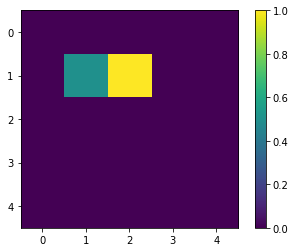

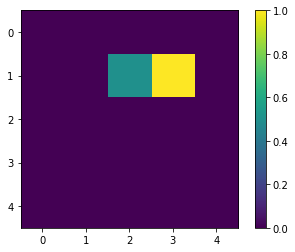

In [6]:
# Right movement of two pixels across a 5x5 image
A = np.full((5, 5, 3), [0, 0, 0], dtype=np.float32)
A[(1, 1)] = [0.5, 0.5, 0.5]
A[(1, 2)] = [1, 1, 1]

B = np.full((5, 5, 3), [0, 0, 0], dtype=np.float32)
B[(1, 1)] = [0, 0, 0]
B[(1, 2)] = [0, 0, 0]
B[(1, 2)] = [0.5, 0.5, 0.5]
B[(1, 3)] = [1, 1, 1]

plt.imshow(np.mean(A, axis=2))
plt.colorbar()
plt.show()

plt.imshow(np.mean(B, axis=2))
plt.colorbar()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

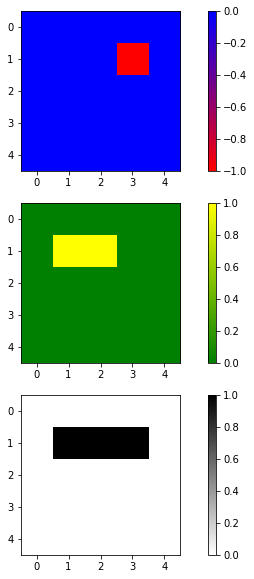

In [7]:
mvt = pma(A, B, search_range=1)
plot_images_motion_vectors(mvt, A.shape)

Processing of the movement on the first two frames using PMA (Pixel Matching Algorithm)

  0%|          | 0/320 [00:00<?, ?it/s]

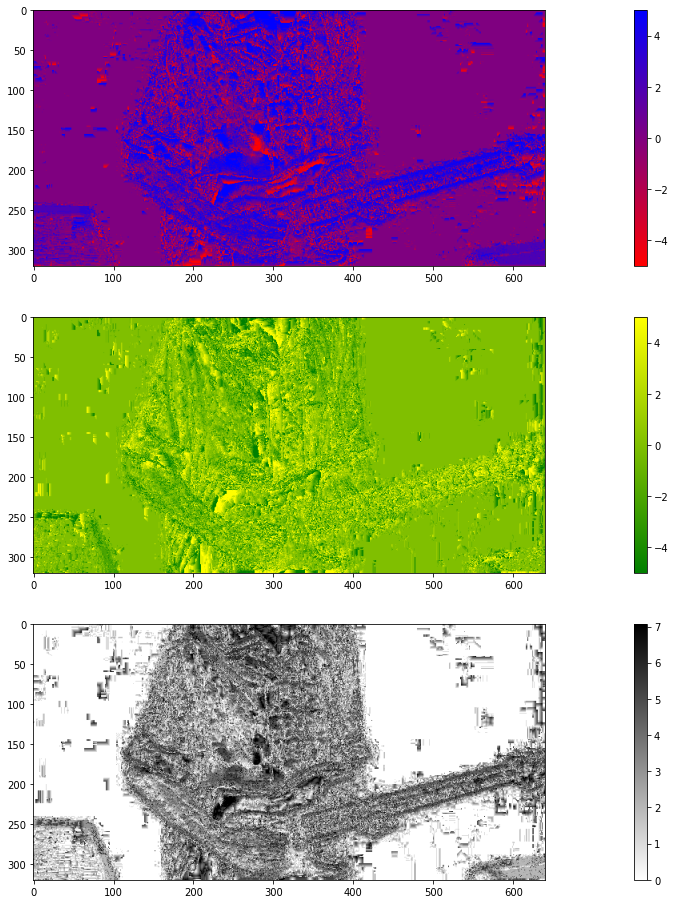

In [8]:
vectors = pma(images[0], images[1], 5)
plot_images_motion_vectors(vectors, images[0].shape)

### (B) BMA (Block Matching Algorithm)

Implementation

In [9]:
def bma_block(frame1, frame2, block_size):
    """
    Calculate the motion vector matrix using the BMA algorithm
    """

    # Average the frames to get intensity images (mean gray)
    frame1 = np.mean(frame1, axis=2)
    frame2 = np.mean(frame2, axis=2)
    
    # Sliding window range around the intensity pixel (IP)
    search_range = block_size

    # Ignore borders of the image to avoid border cases
    # Possible improvement : pad with zeros instead
    hpad = block_size // 2 + search_range
    wpad = block_size // 2 + search_range

    # Calculate image size (constant across all frames)
    height, width = frame1.shape[:2]

    # Vector field matrix
    vector_field = np.zeros((height, width, 2), dtype=np.float32)

    # Iterate over each IP in the current frame
    for i in trange(height):
        for j in range(width):
            
            # Extract the current block (block around the center IP (i, j)) and avoid corners
            current_block = frame1[i+hpad:i+hpad+block_size, j+wpad:j+wpad+block_size]

            # Initialize the error and motion vector for the window sliding block
            best_error = np.inf
            best_motion = np.zeros((2,), dtype=np.float32)

            # Iterate over each pixel in the search range (sliding window)
            # Max and min assure not to slide outside the image ranges
            for k in range(max(i-search_range, 0), min(i+search_range, height-block_size)):
                for l in range(max(j-search_range, 0), min(j+search_range, width-block_size)):
                    # Extract the window block from frame2
                    window_block = frame2[k+hpad:k+hpad+block_size, l+wpad:l+wpad+block_size]

                    # Calculate the mean absolute error and squared distance between the current block (in frame 1)
                    # and the search block (sliding window block in frame 2)
                    try:
                        error = np.mean(np.abs(current_block - window_block))
                    except:
                        continue

                    # Calculate the distance between the current IP and the search IP
                    # In order to prioritize the closest IP if the error is equal
                    distance = np.sum(np.array([l-j, k-i])**2)

                    # (If the current error is lower update the best error
                    # or if the current error is equal but the distance lower) then
                    # update the motion vector
                    if error < best_error or (error == best_error and distance < np.sum(best_motion**2)):	
                        best_error = error
                        best_motion = np.array([l-j, k-i], dtype=np.float32)

            # Store the best motion vector for the current IP (at the center of the block) in the vector field
            vector_field[i, j] = best_motion

    return vector_field

Processing of the movement on the first two frames for a block_size of 5 (2 radius)

  0%|          | 0/320 [00:00<?, ?it/s]

c:\Users\Tom\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Tom\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


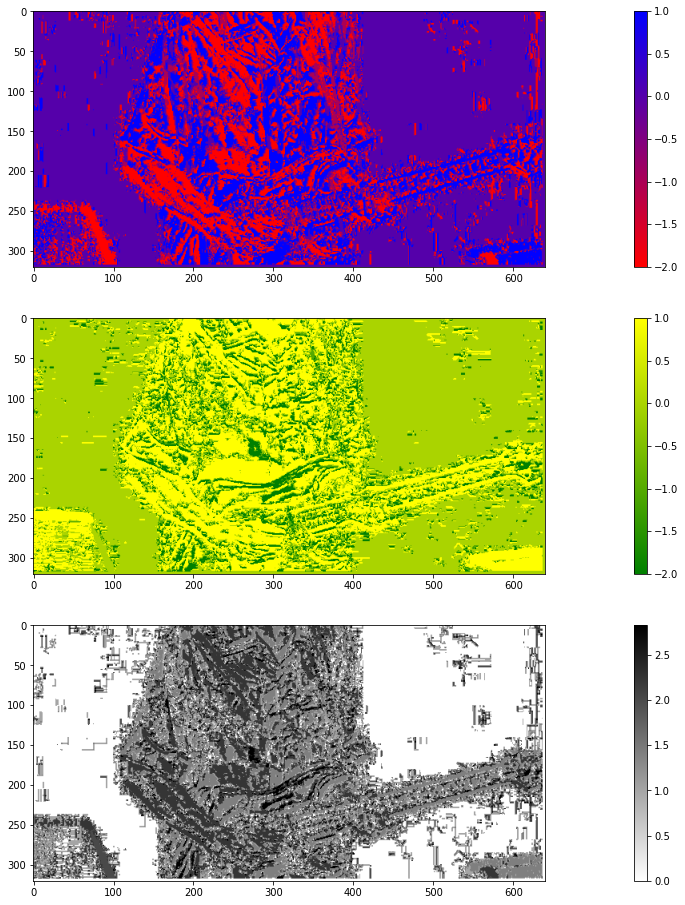

In [10]:
vectors = bma_block(images[0], images[1], 2)
plot_images_motion_vectors(vectors, images[0].shape)

Processing of the movement on the first two frames for a block_size of 10 (5 radius)

  0%|          | 0/320 [00:00<?, ?it/s]

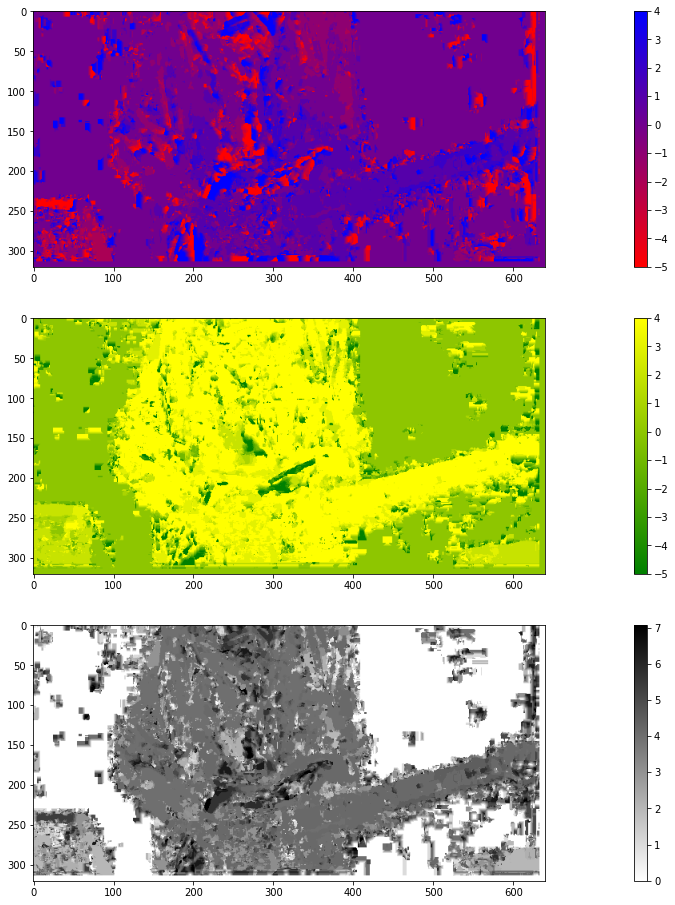

In [11]:
vectors = bma_block(images[0], images[1], 5)
plot_images_motion_vectors(vectors, images[0].shape)

Processing of the movement on the first two frames for a block_size of 20 (10 radius)

In [12]:
vectors = bma_block(images[0], images[1], 10)
plot_images_motion_vectors(vectors, images[0].shape)

  0%|          | 0/320 [00:00<?, ?it/s]

### (C) Que déduisez vous des deux premières questions ?
J'en déduis que la taille des blocs influe fortement sur la régularité du champs de vecteurs de mouvement, en effet plus celle-ci est grande plus le champ de vecteurs de mouvement est régulié et cohérent avec le mouvement réel, de plus les formes des objets sont plus définies par le mouvement et beaucoup moins sur les bords des objets (exemple : les motifs de la chemise sont ignorés au profit du mouvement).

### (D)

#### (D.1) Ajout d'une méthode de régularisation du champ de vecteurs de mouvement

#### (D.2) Estimation de mouvement Node-based

##### (D.2.A) Sans régularisation

##### (D.2.B) Avec régularisation

##### (D.2.C) Qu’observez vous par rapport a la méthode par blocs ?

#### (D.3) Estimation de mouvement Mesh-based avec une descente de gradients (approximé par les différences finies)

##### (D.3.A) Sans régularisation

##### (D.3.B) Avec régularisation

##### (D.3.C) Pourquoi utilise-t-on une descente de gradients ?

##### (D.3.D) Vos estimations de champs de vecteurs sont elles plus ou moins régulières que le cas avec blocs ?